# Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime as dt

In [3]:
# Загрузка данных
df = pd.read_csv('to-modal.csv', parse_dates=['dt'], index_col='dt')

# Выбор целевой переменной
target = df['diff_log_boxcox'].dropna()

# Проверка стационарности (например, с помощью теста Дики-Фуллера)
from statsmodels.tsa.stattools import adfuller
result = adfuller(target)
print(f"ADF p-value: {result[1]:.4f}")  # Если p-value > 0.05, ряд нестационарен

ADF p-value: 0.0000


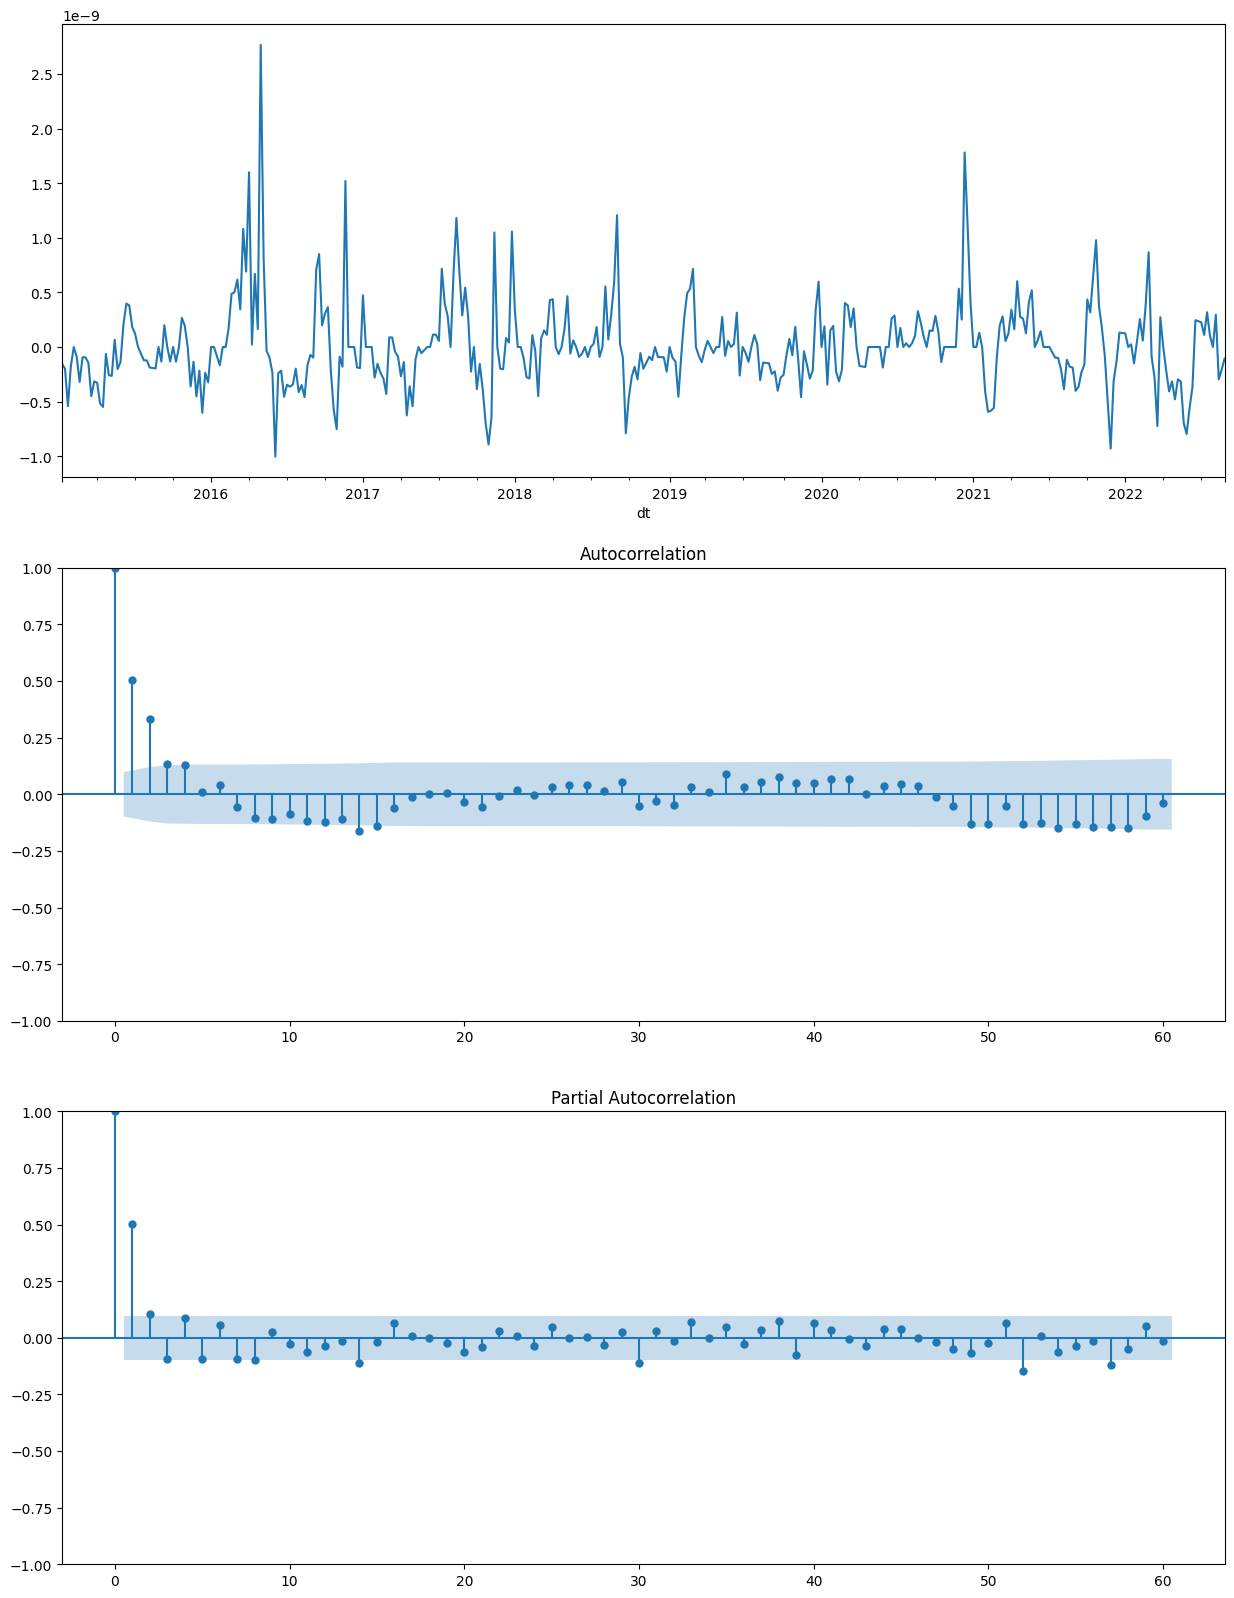

In [4]:
# вывод кареллограмм и ? (аргументировать зачем)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
df['diff_log_boxcox'].plot(ax=ax[0])
plot_acf(df['diff_log_boxcox'], lags=60, ax=ax[1])
plot_pacf(df['diff_log_boxcox'], lags=60, ax=ax[2]);

In [5]:
# Разделение данных
test_size = int(len(target) * 0.2)
train, test = target.iloc[:-test_size], target.iloc[-test_size:]

In [6]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = df.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

# Модели

## SARIMAX

In [7]:
# import warnings
# import itertools
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# warnings.filterwarnings("ignore")

# def search_optimal_sarima(time_series, seasonal_cycle):
#   order_vals = diff_vals = ma_vals = range(0, 2)
#   pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
#   seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
      
#   smallest_aic = float("inf")
#   optimal_order_param = optimal_seasonal_param = None

#   for order_param in pdq_combinations:
#       for seasonal_param in seasonal_combinations:
#           try:
#               sarima_model = SARIMAX(time_series,
#                                                         order=order_param,
#                                                         seasonal_order=seasonal_param,
#                                                         enforce_stationarity=False,
#                                                         enforce_invertibility=False)

#               model_results = sarima_model.fit()
#               if model_results.aic < smallest_aic:
#                   smallest_aic = model_results.aic
#                   optimal_order_param = order_param
#                   optimal_seasonal_param = seasonal_param
#           except:
#               continue

#   print('ARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))

# seasonal_cycle_length = 12
# search_optimal_sarima(train, seasonal_cycle_length)

In [8]:
# # Обучение модели
# order = (3, 0, 1)  # (p, d, q)
# seasonal_order = (2, 1, 0, 12)  # (P, D, Q, S), где S — сезонность

# # Создание и обучение модели
# model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
# results = model.fit(disp=False)

# # Прогноз на тестовой выборке
# forecast = results.get_forecast(steps=len(test))
# predicted = forecast.predicted_mean
# confidence_interval = forecast.conf_int()

## что то с грид серчем

In [9]:
# data = df.asfreq('MS')
# data = data['y']
# data = data.sort_index()

# # Data partition train-test
# # ==============================================================================
# end_train = '2005-06-01 23:59:00'
# print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
# print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# # Plot
# # ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3))
# data.loc[:end_train].plot(ax=ax, label='train')
# data.loc[end_train:].plot(ax=ax, label='test')
# ax.legend();

In [10]:
# # Create and fit a recursive multi-step forecaster (ForecasterAutoreg)
# # ==============================================================================
# forecaster = ForecasterAutoreg(
#                  regressor = RandomForestRegressor(random_state=123),
#                  lags      = 15
#              )

# forecaster.fit(y=data.loc[:end_train])
# forecaster

In [11]:
# # Libraries
# # ==============================================================================
# import pandas as pd
# import matplotlib.pyplot as plt
# from skforecast.model_selection import grid_search_sarimax

# param_grid = {'order': [(12, 0, 0), (12, 2, 0), (12, 1, 0), (12, 1, 1), (14, 1, 4)],
#              'seasonal_order': [(0, 0, 0, 0)],
#              'trend': [None, 'n', 'c']}

# results_grid = grid_search_sarimax(
#     forecaster = forecaster,
#     y = df.loc[:'2006-01-01'],
#     param_grid = param_grid,
#     metric = 'mean_absolute_error',
#     verbose = False,
#     cv=
#     )

# results_grid


## catboost

добавить больше лагов?

In [12]:
from catboost import CatBoostRegressor

In [13]:
# Подготовка данных
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['quarter'] = df.index.quarter 

for lag in [1, 2, 3, 6, 12]:
    df[f'lag_{lag}'] = df['diff_log_boxcox'].shift(lag)
    
df = df.dropna()

In [14]:
df

,Цена на арматуру,log_price,log_price_boxcox,diff_log_boxcox,year,month,day,quarter,lag_1,lag_2,lag_3,lag_6,lag_12
dt,,,,,,,,,,,,,
2015-04-06,26600,10.188666,0.147781,-3.272876e-10,2015,4,6,2,-3.148183e-10,-4.504494e-10,-1.446795e-10,-3.198951e-10,-1.549008e-10
2015-04-13,25700,10.154246,0.147781,-5.160919e-10,2015,4,13,2,-3.272876e-10,-3.148183e-10,-4.504494e-10,-9.386608e-11,-1.983760e-10
2015-04-20,24800,10.118599,0.147781,-5.490092e-10,2015,4,20,2,-5.160919e-10,-3.272876e-10,-3.148183e-10,-9.500145e-11,-5.421188e-10
2015-04-27,24700,10.114559,0.147781,-6.317899e-11,2015,4,27,2,-5.490092e-10,-5.160919e-10,-3.272876e-10,-1.446795e-10,-1.749764e-10
2015-05-04,24300,10.098232,0.147781,-2.573066e-10,2015,5,4,2,-6.317899e-11,-5.490092e-10,-5.160919e-10,-4.504494e-10,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,47500,10.768485,0.147781,0.000000e+00,2022,8,1,3,1.022672e-10,3.183752e-10,1.101798e-10,2.455756e-10,-2.965745e-10
2022-08-08,49000,10.799576,0.147781,2.959911e-10,2022,8,8,3,0.000000e+00,1.022672e-10,3.183752e-10,2.359010e-10,-3.152636e-10
2022-08-15,47500,10.768485,0.147781,-2.959911e-10,2022,8,15,3,2.959911e-10,0.000000e+00,1.022672e-10,2.268228e-10,-6.947594e-10


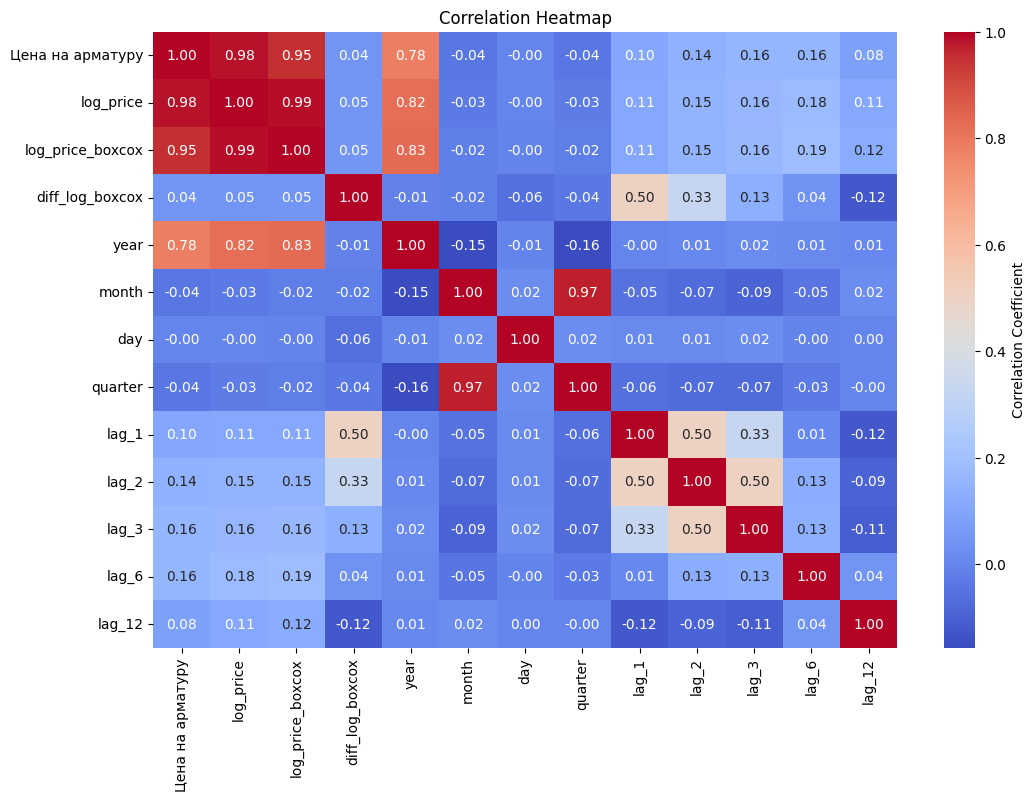

In [15]:
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Heatmap')
plt.show()

In [16]:
# Выбор признаков и целевой переменной
features = ['year', 'month', 'day', 'quarter', 'lag_1', 'lag_2', 'lag_3', 'lag_12']
target = 'diff_log_boxcox'

# Разделение на обучающую и тестовую выборки
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [17]:
# Создание и обучение модели
model = CatBoostRegressor(iterations=1000, 
                          learning_rate=0.1, 
                          depth=6, 
                          loss_function='RMSE',
                          verbose=200)

model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          early_stopping_rounds=50)

# Прогнозирование
predictions = model.predict(X_test)

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 162ms	remaining: 2m 42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.749182539e-10
bestIteration = 37

Shrink model to first 38 iterations.


In [18]:
predictions

array([-1.42630869e-10,  4.62467382e-11,  8.98375580e-11,  2.33808978e-11,
        2.51408341e-11,  1.13823939e-10,  1.12253071e-10,  2.14946296e-10,
        3.93876613e-10,  1.34694174e-10,  1.03605445e-10,  1.50135118e-10,
        1.44834919e-10,  4.88906275e-11,  4.00609058e-11,  5.58676202e-11,
       -3.30249945e-12, -4.17107641e-12, -2.23184580e-11, -4.00210908e-11,
       -5.72070788e-11, -7.20792295e-11, -1.88181834e-10, -2.39220028e-10,
       -1.66934411e-10, -1.25151669e-10, -1.60541802e-10, -2.12640788e-10,
       -2.39849538e-10, -1.91709863e-10, -1.10135752e-10,  1.48759753e-10,
        2.71128457e-10,  2.67431228e-10,  2.46381651e-10,  2.13453521e-10,
        1.57091371e-10, -2.12348628e-11, -1.61391175e-10, -1.83837282e-10,
       -7.84254322e-11,  1.73633351e-12,  8.90872894e-11, -5.71278190e-13,
        4.97395215e-13, -7.70370856e-11, -6.15790118e-11, -1.56240796e-10,
       -5.48427311e-11,  8.12485528e-11,  6.63921406e-12,  1.41363349e-10,
        1.79227611e-10,  

In [19]:
# Оценка модели
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 0.00
MSE: 0.00
RMSE: 0.00
R²: 0.3841


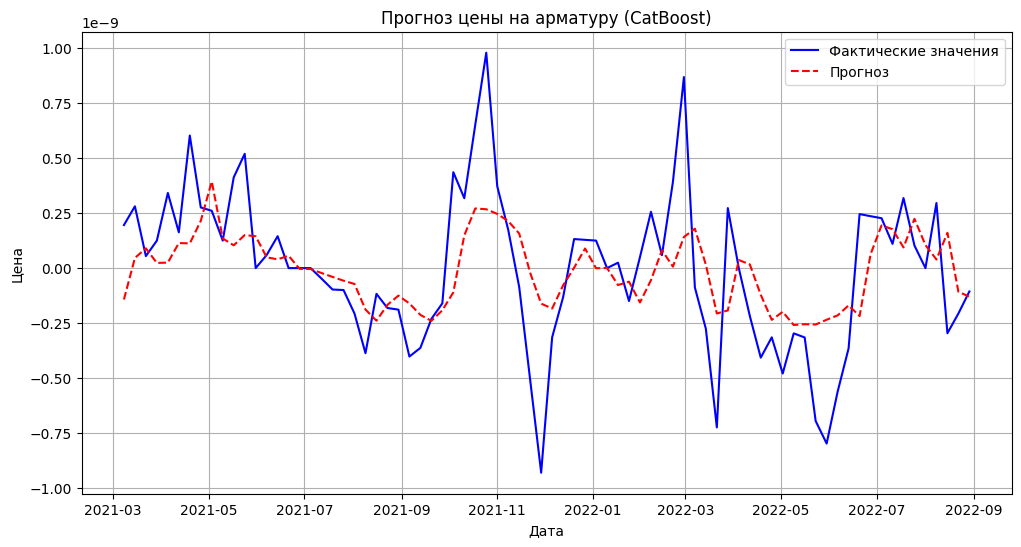

In [20]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Фактические значения', color='blue')
plt.plot(test.index, predictions, label='Прогноз', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (CatBoost)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

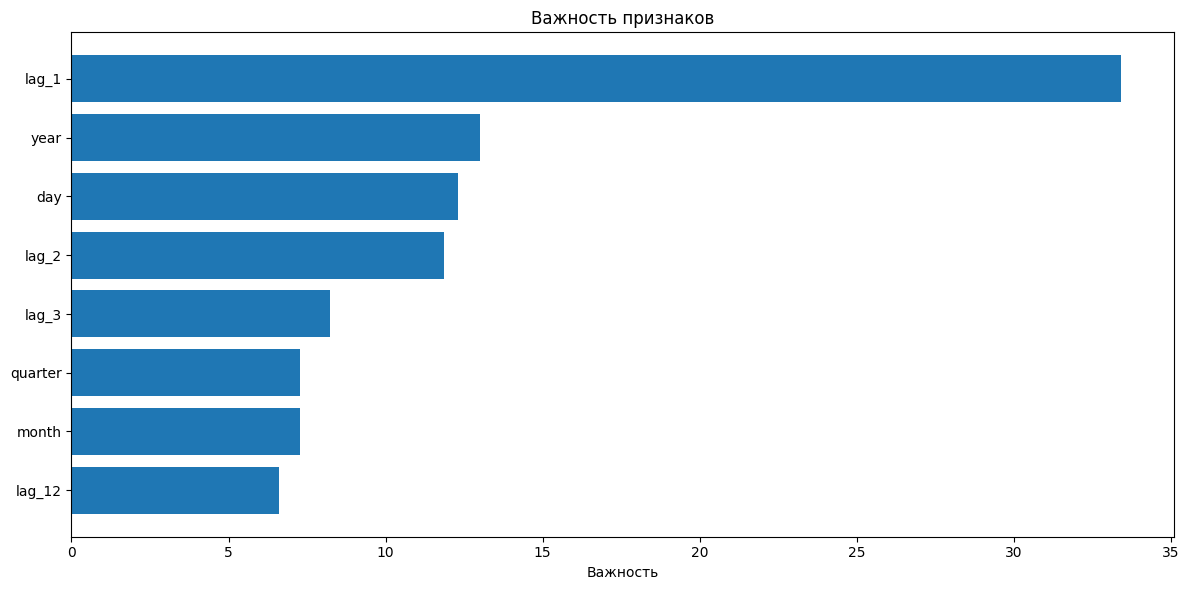

In [21]:
# Важность признаков
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

## возвращение значений обратно

In [22]:
predictions

array([-1.42630869e-10,  4.62467382e-11,  8.98375580e-11,  2.33808978e-11,
        2.51408341e-11,  1.13823939e-10,  1.12253071e-10,  2.14946296e-10,
        3.93876613e-10,  1.34694174e-10,  1.03605445e-10,  1.50135118e-10,
        1.44834919e-10,  4.88906275e-11,  4.00609058e-11,  5.58676202e-11,
       -3.30249945e-12, -4.17107641e-12, -2.23184580e-11, -4.00210908e-11,
       -5.72070788e-11, -7.20792295e-11, -1.88181834e-10, -2.39220028e-10,
       -1.66934411e-10, -1.25151669e-10, -1.60541802e-10, -2.12640788e-10,
       -2.39849538e-10, -1.91709863e-10, -1.10135752e-10,  1.48759753e-10,
        2.71128457e-10,  2.67431228e-10,  2.46381651e-10,  2.13453521e-10,
        1.57091371e-10, -2.12348628e-11, -1.61391175e-10, -1.83837282e-10,
       -7.84254322e-11,  1.73633351e-12,  8.90872894e-11, -5.71278190e-13,
        4.97395215e-13, -7.70370856e-11, -6.15790118e-11, -1.56240796e-10,
       -5.48427311e-11,  8.12485528e-11,  6.63921406e-12,  1.41363349e-10,
        1.79227611e-10,  

In [23]:
test

,Цена на арматуру,log_price,log_price_boxcox,diff_log_boxcox,year,month,day,quarter,lag_1,lag_2,lag_3,lag_6,lag_12
dt,,,,,,,,,,,,,
2021-03-08,49000,10.799576,0.147781,1.955602e-10,2021,3,8,1,-9.864692e-11,-5.571043e-10,-5.834700e-10,0.000000e+00,1.782332e-09
2021-03-15,50500,10.829729,0.147781,2.808121e-10,2021,3,15,1,1.955602e-10,-9.864692e-11,-5.571043e-10,-4.019225e-10,1.124158e-09
2021-03-22,50800,10.835652,0.147781,5.444989e-11,2021,3,22,1,2.808121e-10,1.955602e-10,-9.864692e-11,-5.935780e-10,4.135213e-10
2021-03-29,51500,10.849337,0.147781,1.249291e-10,2021,3,29,1,5.444989e-11,2.808121e-10,1.955602e-10,-5.834700e-10,0.000000e+00
2021-04-05,53500,10.887437,0.147781,3.414249e-10,2021,4,5,2,1.249291e-10,5.444989e-11,2.808121e-10,-5.571043e-10,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,47500,10.768485,0.147781,0.000000e+00,2022,8,1,3,1.022672e-10,3.183752e-10,1.101798e-10,2.455756e-10,-2.965745e-10
2022-08-08,49000,10.799576,0.147781,2.959911e-10,2022,8,8,3,0.000000e+00,1.022672e-10,3.183752e-10,2.359010e-10,-3.152636e-10
2022-08-15,47500,10.768485,0.147781,-2.959911e-10,2022,8,15,3,2.959911e-10,0.000000e+00,1.022672e-10,2.268228e-10,-6.947594e-10


In [24]:
# # Выберите первый элемент теста
# test_index = test.index[0]
# true_value = df.loc[test_index, 'Цена на арматуру']

# # Восстановите предсказание вручную
# last_log = train['log_normalized_price'].iloc[-1]
# pred_diff = predictions[0]  # Первое предсказанное diff
# reversed_log = last_log + pred_diff
# reversed_normalized = np.exp(reversed_log) - 1e-10

# window = 12
# # Вычислите rolling_std только на исторических данных
# history_std = train['Цена на арматуру'].iloc[-window:].std()
# reversed_price = reversed_normalized * (history_std if history_std != 0 else 1)

# print(f"Предсказание: {reversed_price:.2f}, Истинное: {true_value:.2f}")

In [25]:
def inverse_stationarization(diff_series, initial_value, lambda_):
    # Восстанавливаем log_price_boxcox из разностного ряда
    restored_log_price_boxcox = diff_series.cumsum() + initial_value
    
    # Обратное преобразование Бокса-Кокса
    if lambda_ == 0:
        restored_log_price = np.exp(restored_log_price_boxcox)
    else:
        restored_log_price = (restored_log_price_boxcox * lambda_ + 1) ** (1 / lambda_)
    
    # Экспонента для получения исходной цены (в абсолютном значении)
    restored_price = np.exp(restored_log_price)
    
    return restored_price

In [ ]:
# Сохраняем начальное значение и параметры перед дифференцированием
initial_value = df['log_price_boxcox'].iloc[0]  # Значение до diff()
lambda_ = lambda_  # Параметр из boxcox преобразования

# Применяем обратную трансформацию
restored_prices = inverse_stationarization(
    test['diff_log_boxcox'], 
    initial_value, 
    lambda_
)


NameError: name 'lambda_' is not defined

In [ ]:
predictions_original

array([46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000.])

In [ ]:
# def inverse_transform(predictions, train, window):
#     if len(predictions) == 0:
#         return np.array([])
    
#     # Проверка соответствия размеров
#     if len(predictions) > len(train):
#         raise ValueError("len(predictions) не может превышать len(train)")
    
#     # Последнее значение log_normalized_price из train
#     last_log = train["log_normalized_price"].iloc[-1]
    
#     # Интегрируем предсказания
#     reversed_log = np.concatenate([[last_log], predictions]).cumsum()[1:]
#     reversed_normalized = np.exp(reversed_log) - 1e-10
    
#     # Расчёт rolling_std для каждого шага прогноза
#     rolling_std_values = []
#     for i in range(len(predictions)):
#         end_idx = len(train) - len(predictions) + i + 1
#         window_data = train["Цена на арматуру"].iloc[max(0, end_idx - window):end_idx]
#         current_std = window_data.std()
#         rolling_std_values.append(current_std if current_std != 0 else 1)
    
#     # Отмена нормализации
#     final_predictions = reversed_normalized * np.array(rolling_std_values)
    
#     return final_predictions

# # Восстанавливаем цены
# restored_prices = inverse_transform(predictions, train, window=12)

true_prices = test["Цена на арматуру"].values
# mae = np.mean(np.abs(restored_prices - true_prices))
# print(f"MAE: {mae:.2f}")  # Должно быть близко к 0

In [ ]:
# last_known_value = train['log_normalized_price'].iloc[- 1]

# reversed_diff = predictions.cumsum() + last_known_value
# reversed_diff = np.nan_to_num(reversed_diff, nan=0.0, posinf=0.0, neginf=0.0)

# reversed_log = np.exp(reversed_diff) - 1e-10

# rolling_std_train = train['rolling_std'].iloc[-len(predictions):].values

# # rolling_std_test = np.where(rolling_std_train == 0, 1, rolling_std_test)

# reversed_normalized = reversed_log * rolling_std_train

# # Original true prices from the test set
# original_true_prices = df_true.loc[test.index, 'Цена на арматуру'].values

# reversed_normalized

# # 6. Считаем метрики
# mae = mean_absolute_error(original_true_prices, reversed_normalized)
# mse = mean_squared_error(original_true_prices, reversed_normalized)
# rmse = np.sqrt(mse)
# r2 = r2_score(original_true_prices, reversed_normalized)

# print(f"MAE: {mae:.2f}")
# print(f"MSE: {mse:.2f}")
# print(f"RMSE: {rmse:.2f}")
# print(f"R²: {r2:.4f}")

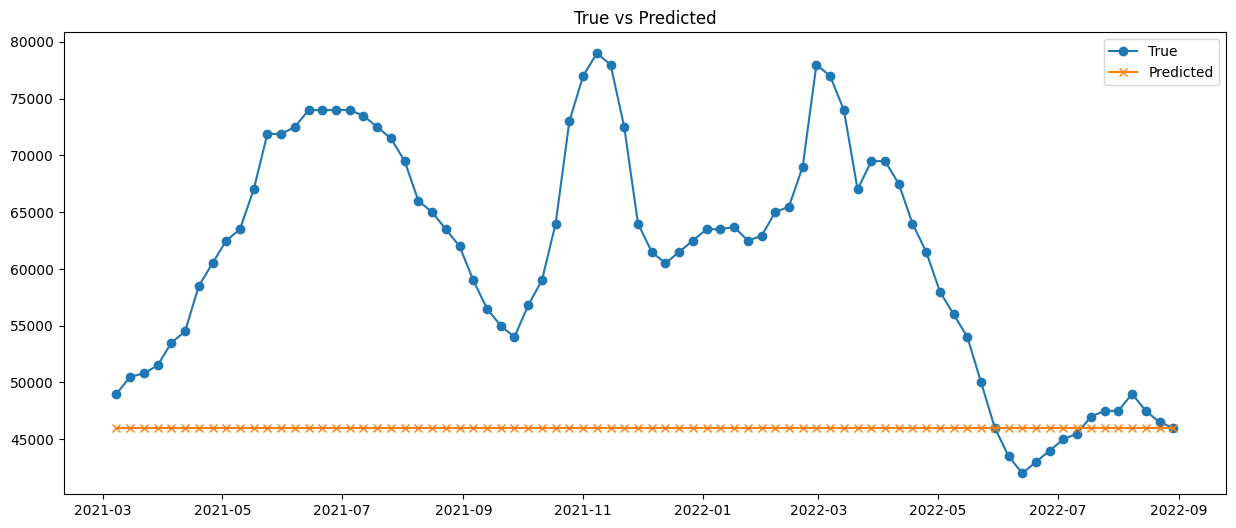

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(test.index, true_prices, label='True', marker='o')
plt.plot(test.index, predictions_original, label='Predicted', marker='x')
plt.legend()
plt.title("True vs Predicted")
plt.show()

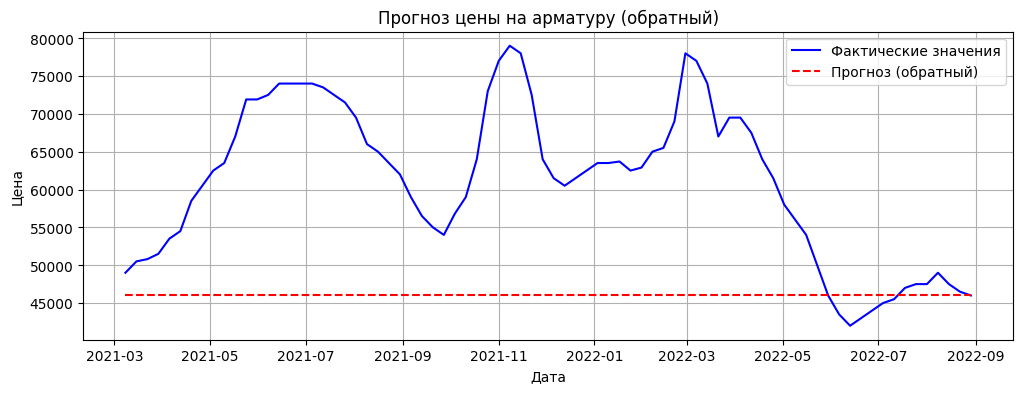

In [ ]:
# Visualize the results
plt.figure(figsize=(12, 4))
plt.plot(test.index, true_prices, label='Фактические значения', color='blue')
plt.plot(test.index, predictions_original, label='Прогноз (обратный)', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (обратный)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predictions_original

array([46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000., 46000., 46000.,
       46000., 46000., 46000., 46000., 46000., 46000.])

# Проверка прогноза

In [ ]:
# # Визуализация предсказания
# plt.figure(figsize=(12, 6))
# plt.plot(train.index, train, label='Обучающая выборка', color='blue')
# plt.plot(test.index, test, label='Фактические значения', color='purple')
# plt.plot(test.index, predicted, label='Прогноз', color='red', linestyle='--')
# plt.fill_between(test.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.2)
# plt.title('Прогноз цены на арматуру')
# plt.xlabel('Дата')
# plt.ylabel('Цена')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Метрики
# mae = mean_absolute_error(test, predicted)
# mse = mean_squared_error(test, predicted)
# rmse = np.sqrt(mse)
# mape = np.mean(np.abs((test - predicted) / test)) * 100
# r2 = r2_score(test, predicted)

# print(f"MAE: {mae:.2f}")
# print(f"MSE: {mse:.2f}")
# print(f"RMSE: {rmse:.2f}")
# print(f"MAPE: {mape:.2f}%")
# print(f"R²: {r2:.4f}")